In [1267]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from matplotlib import colormaps as cm
from pathlib import Path
from torch.utils.data import DataLoader
from data.data import InvERTDataset
from model.models import UNet
from json5 import load as json_load
import cv2

In [1268]:
with open("/mnt/ensg/tout_le_monde/Basile/dataset_sensitivity_5_5_cosine_tape/overall_statistics.txt", "r", encoding='utf8') as minmaxfile:
    lines = minmaxfile.readlines()
min_dataset = float(eval(lines[-1].strip().split()[3].strip(',')))
max_dataset = float(eval(lines[-1].strip().split()[5].strip('}')))
print(min_dataset)
print(max_dataset)

0.0
10.673124313354492


In [1269]:
experiment_path = Path("/mnt/ensg/tout_le_monde/Basile/results/no_pad_no_resize_sum_weight_06-05-2025_08h07")

model_ckpt_path = experiment_path / "figures/model_output/checkpoints"
model_ckpt_list = sorted(model_ckpt_path.glob("model_epoch*.pth"), key=lambda x: int(x.stem.split("_")[-1]))
print(f"Found {len(model_ckpt_list)} checkpoints, last one is {model_ckpt_list[-1].stem}")
model = UNet()
model.load_state_dict(torch.load(model_ckpt_list[-1], map_location='cpu')['model_state_dict'])
model.eval()

Found 30 checkpoints, last one is model_epoch_30


UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): InstanceNor

In [1270]:
with open(experiment_path / 'config.json5', mode='r', encoding="utf8") as config_file:
    config_dict = json_load(config_file)


class Transform:
    def __init__(self):
        pass

    def __call__(self, sample):
        pseudosection = sample['pseudosection'].unsqueeze(0)
        num_electrode_channel = torch.ones_like(pseudosection) * sample['num_electrode']
        subsection_length_channel = torch.ones_like(pseudosection) * sample['subsection_length']
        array_type_channel = sample['array_type']
        array_type_channel = array_type_channel.view(-1, 1, 1).expand(-1, pseudosection.shape[1], pseudosection.shape[2])
        sample['pseudosection'] = torch.cat((pseudosection, num_electrode_channel, subsection_length_channel, array_type_channel), dim=0)
        
        sample['norm_log_resistivity_model'] = sample['norm_log_resistivity_model'].unsqueeze(0)
        sample['JtJ_diag'] = sample['JtJ_diag'].unsqueeze(0)
        # sample['JtJ_diag'] = torch.ones_like(sample['JtJ_diag'])
        
        return sample

dataset = InvERTDataset(
    Path(config_dict['dataset']['dataset_name']),
    transform=Transform(),
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

DATASET: Found 14704 samples in /home/labo3A/samples_norm/samples_norm.


In [1271]:
sample = next(iter(dataloader))

# while torch.isclose(sample['norm_log_resistivity_model'].squeeze().mean(axis=1)[0], sample['norm_log_resistivity_model'].squeeze()[0, 10]):
#     sample = next(iter(dataloader))

norm_pseudosection = sample['pseudosection']
norm_resistivity_model = sample['norm_log_resistivity_model']
norm_JtJ_diag = sample['JtJ_diag']

output = model(norm_pseudosection, norm_resistivity_model)

In [1272]:
pseudosection_npn = norm_pseudosection.squeeze().numpy()[0]
pseudosection_npn = np.where(pseudosection_npn <= 0, np.nan, pseudosection_npn)

norm_output_np = output.squeeze().detach().numpy()
norm_model_np = norm_resistivity_model.squeeze().numpy()

norm_JtJ_diag_np = norm_JtJ_diag.squeeze().numpy()

vmin_m = min(np.min(norm_output_np), np.min(norm_model_np))
vmax_m = max(np.max(norm_output_np), np.max(norm_model_np))
norm_m = Normalize(vmin=vmin_m, vmax=vmax_m)

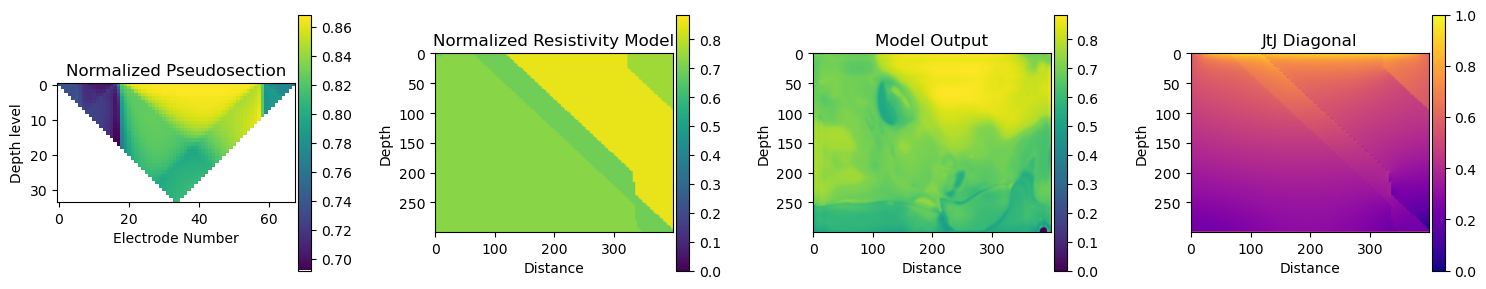

In [1273]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

im = axes[0].imshow(pseudosection_npn)
axes[0].set_title("Normalized Pseudosection")
axes[0].set_xlabel("Electrode Number")
axes[0].set_ylabel("Depth level")
plt.colorbar(im, ax=axes[0], orientation='vertical', pad=0.01)


im = axes[1].imshow(norm_model_np, norm=norm_m)
axes[1].set_title("Normalized Resistivity Model")
axes[1].set_xlabel("Distance")
axes[1].set_ylabel("Depth")
plt.colorbar(im, ax=axes[1], orientation='vertical', pad=0.01)

im = axes[2].imshow(norm_output_np, norm=norm_m)
axes[2].set_title("Model Output")
axes[2].set_xlabel("Distance")
axes[2].set_ylabel("Depth")
plt.colorbar(im, ax=axes[2], orientation='vertical', pad=0.01)

im = axes[3].imshow(norm_JtJ_diag_np, cmap='plasma')
axes[3].set_title("JtJ Diagonal")
axes[3].set_xlabel("Distance")
axes[3].set_ylabel("Depth")
plt.colorbar(im, ax=axes[3], orientation='vertical', pad=0.01)

plt.tight_layout()
plt.show()

In [1274]:
def detransform(log_res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return np.exp(log_res * np.log(50000)).astype(log_res.dtype)

In [1275]:
n_e = sample['num_electrode'].item()
w = sample['subsection_length'].item()

n_e = round(n_e * (96 - 24) + 24)
print(f"Number of electrodes: {n_e}")

w = round(w * (200 - 24) + 24)
print(f"Subsection length: {w} m")

h = round(0.75 * 200)
print(f"Height: {h} m")

W = norm_output_np.shape[1]
H = norm_output_np.shape[0]
print(f"Width: {W} px")
print(f"Height: {H} px")

depth = 50
depth_to_pix = int(depth * H / h)

Number of electrodes: 71
Subsection length: 127 m
Height: 150 m
Width: 400 px
Height: 300 px


In [1276]:
pseudosection_np = np.exp(pseudosection_npn * (max_dataset - min_dataset) + min_dataset) - 1
model_np = detransform(norm_model_np)[:depth_to_pix, :]
output_np = detransform(norm_output_np)[:depth_to_pix, :]

vmin_mnp = min(np.min(output_np), np.min(model_np))
vmax_mnp = max(np.max(output_np), np.max(model_np))
norm_mnp = LogNorm(vmin=vmin_mnp, vmax=vmax_mnp)

JtJ_diag_np = norm_JtJ_diag_np[:depth_to_pix, :]

error = (np.abs(output_np - model_np) * JtJ_diag_np) / model_np + 1e-10
vmin_e = np.min(error)
vmax_e = np.max(error)
log_norm_e = LogNorm(vmin=1e-3, vmax=0.5)
norm_e = Normalize(vmin=vmin_e, vmax=vmax_e)

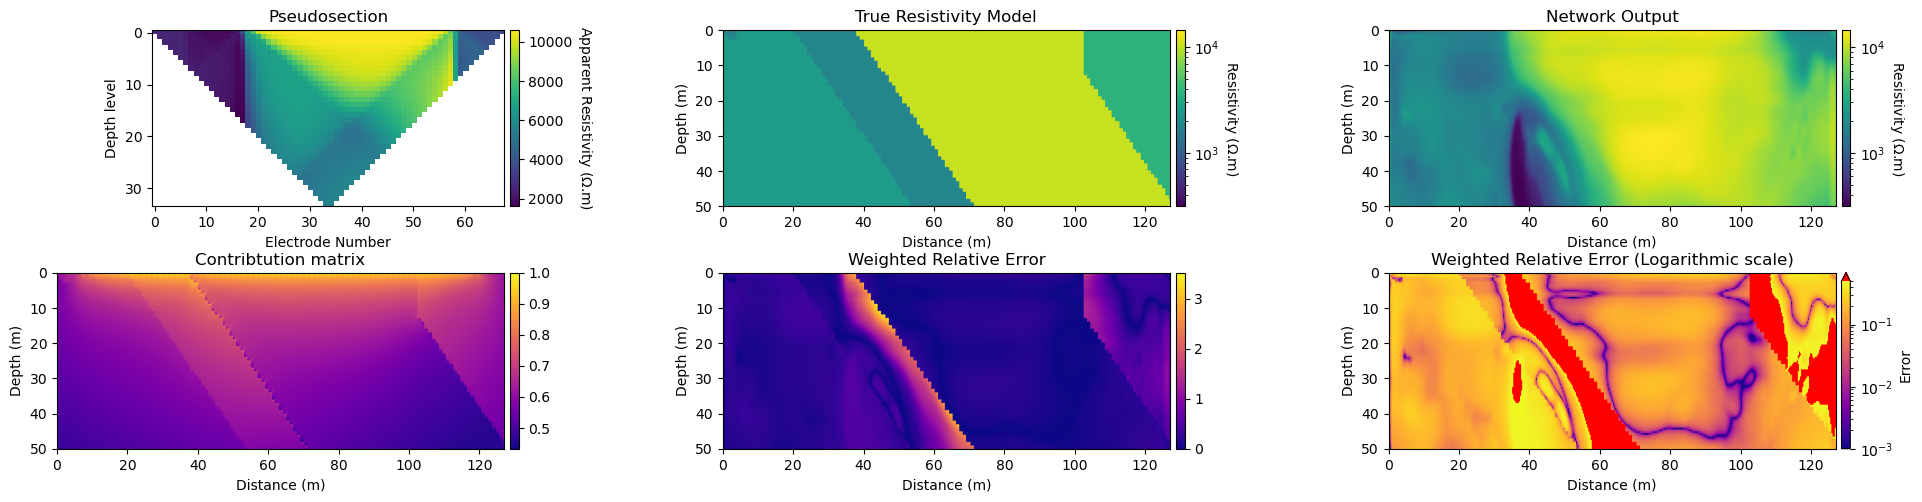

In [1277]:
fig, axes = plt.subplots(2, 3, figsize=(20, 5))
axes = axes.flatten()

im = axes[0].imshow(pseudosection_np)
axes[0].set_title("Pseudosection")
axes[0].set_xlabel("Electrode Number")
axes[0].set_ylabel("Depth level")
clb = plt.colorbar(im, ax=axes[0], orientation='vertical', pad=0.01)
clb.ax.set_ylabel(r"Apparent Resistivity ($\Omega$.m)", rotation=270, labelpad=15)


im = axes[1].imshow(model_np, norm=norm_mnp, extent=[0, w, depth, 0])
axes[1].set_title("True Resistivity Model")
axes[1].set_xlabel("Distance (m)")
axes[1].set_ylabel("Depth (m)")
clb = plt.colorbar(im, ax=axes[1], orientation='vertical', pad=0.01)
clb.ax.set_ylabel(r"Resistivity ($\Omega$.m)", rotation=270, labelpad=15)

im = axes[2].imshow(output_np, norm=norm_mnp, extent=[0, w, depth, 0])
axes[2].set_title("Network Output")
axes[2].set_xlabel("Distance (m)")
axes[2].set_ylabel("Depth (m)")
clb = plt.colorbar(im, ax=axes[2], orientation='vertical', pad=0.01)
clb.ax.set_ylabel(r"Resistivity ($\Omega$.m)", rotation=270, labelpad=15)

im = axes[3].imshow(JtJ_diag_np, cmap='plasma', extent=[0, w, depth, 0])
axes[3].set_title("Contribtution matrix")
axes[3].set_xlabel("Distance (m)")
axes[3].set_ylabel("Depth (m)")
plt.colorbar(im, ax=axes[3], orientation='vertical', pad=0.01)

im = axes[4].imshow(error, cmap='plasma', norm=norm_e, extent=[0, w, depth, 0])
axes[4].set_title("Weighted Relative Error")
axes[4].set_xlabel("Distance (m)")
axes[4].set_ylabel("Depth (m)")
clb = plt.colorbar(im, ax=axes[4], orientation='vertical', pad=0.01)

original_cmap_name = 'plasma'
custom_cmap = cm.get_cmap(original_cmap_name).copy()
custom_cmap.set_over('red') # Values > 1.0 will be colored red

im = axes[5].imshow(error, cmap=custom_cmap, norm=log_norm_e, extent=[0, w, depth, 0])
axes[5].set_title("Weighted Relative Error (Logarithmic scale)")
axes[5].set_xlabel("Distance (m)")
axes[5].set_ylabel("Depth (m)")
clb = plt.colorbar(im, ax=axes[5], orientation='vertical', pad=0.01, extend='max')
clb.set_label("Error")


plt.tight_layout()
plt.show()